In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt
folder = 'training_20180910/'

txts = [file for file in os.listdir(folder) if '.txt' in file]
anns = [file for file in os.listdir(folder) if '.ann' in file]
ids = [file.strip('.txt') for file in txts]

def load_txt(txt=None, i=None):
    '''
    Pass text file name or index to load file
    '''
    if txt is not None:
        with open(folder + txt) as f:
            lines = f.readlines()
        return lines
    elif i is not None:
        with open(folder + txts[i]) as f:
            lines = f.readlines()
        return lines
    
def load_txt(txt=None, i=None):
    '''
    Pass text file name or index to load file
    '''
    if txt is not None:
        with open(folder + txt) as f:
            lines = f.readlines()
        return lines
    elif i is not None:
        with open(folder + txts[i]) as f:
            lines = f.readlines()
        return lines


'''
Get chief complaint and history from medical record
Save to patient_record_summary.csv
'''
patient_text_rows = []
            
for patient_id in ids:
    patient_text = {}
    
    txt = patient_id + '.txt'
    lines = load_txt(txt)
    
    # get chief complaint
    chief_complaint = ''
    chief_complaint_idx = -1
    chief_complaint_end_idx = -1
    
    # start and end of chief complaint
    for i, line in enumerate(lines):
        if 'chief complaint' in line.lower():
            chief_complaint_idx = i
            break
    for j, line in enumerate(lines[i:]):
        if line == '\n':
            chief_complaint_end_idx = j + i
            break
    
    # trim \n and join
    if chief_complaint_idx > -1:
        chief_complaint = lines[chief_complaint_idx:chief_complaint_end_idx]
        chief_complaint = [line.strip('\n') for line in chief_complaint]
        chief_complaint = ' '.join(chief_complaint)
        
    patient_text['chief_complaint'] = chief_complaint

    
    # get present history
    present_history = ''
    present_history_idx = -1
    present_history_end_idx = -1
    
    for i, line in enumerate(lines):
        if 'history of present illness' in line.lower():
            present_history_idx = i
            break
    for j, line in enumerate(lines[i+3:]):
        #find the next header
        if ':' in line:
            present_history_end_idx = j + i + 3
            break
    
    if present_history_idx > -1:
        present_history = lines[present_history_idx:present_history_end_idx]
        present_history = [line.strip('\n') for line in present_history]
        present_history = ' '.join(present_history)
    
    patient_text['present_history'] = present_history
    
    
    patient_text_rows.append(patient_text)
    
patient_df = pd.DataFrame(patient_text_rows, index=ids)
patient_df = patient_df.drop(
    patient_df[((patient_df['chief_complaint'] == '') & 
     (patient_df['present_history'] == ''))].index
)
patient_df = patient_df.fillna('')
patient_df.dropna(subset=['chief_complaint', 'present_history'], how='all')
patient_df.to_csv('patient_record_summary.csv')

In [2]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace
import torch

import pandas as pd
import matplotlib.pyplot as plt


patient_df = pd.read_csv('patient_record_summary.csv')
patient_df = patient_df.fillna('')
lines = list(patient_df['chief_complaint'].str.lower() + ' \n ' + patient_df['present_history'].str.lower())

# train a tokenizer for tf-idf analysis
def train_tokenizer(lines):
    tokenizer = Tokenizer(WordLevel(unk_token='<unk>'))

    trainer = WordLevelTrainer(special_tokens=['<unk>', '<reas>', '<drug>', '<pair>',
                                               '<sep>', '<mask>', '<s>', '</s>'])
    tokenizer.pre_tokenizer = Whitespace()
    tokenizer.train_from_iterator(lines, trainer=trainer)
    
    return tokenizer



In [3]:
def tfidfs(tokenizer, lines, df_shift=0):
    '''
    With a given tokenizer, calculate TF-IDF of set of documents (lines)
    Optionally pass a df_shift to aritificially inflate df count values
    and truncate words that are too common from tf_idfs
    (Also nonlinearly shifts tf-idf scores for other entries)
    '''
    tfs = np.zeros(tokenizer.get_vocab_size())
    
    all_tfs = []
    for line in lines:
        encoded = tokenizer.encode(line).ids
        tfs = np.zeros(tokenizer.get_vocab_size())
        for ids in encoded:
            tfs[ids] += 1
        all_tfs.append(tfs / len(encoded))
        
    tfs_df = pd.DataFrame(all_tfs, columns=range(tokenizer.get_vocab_size()))
    
    df_counts = (((tfs_df != 0) * 1).sum(axis=0))
    df_counts = df_counts + df_shift
    idfs = len(tfs_df) / df_counts
    idfs = np.log(idfs)

    tf_idfs = tfs_df * idfs

    return tfs_df, idfs, tf_idfs

tfs_df, idfs, tf_idfs = tfidfs(tokenizer, lines)
plt.figure(figsize=(8,8))
plt.title('Number of documents word is found in')

plt.scatter(range(tokenizer.get_vocab_size()), (((tfs_df != 0) * 1).sum(axis=0)).sort_values(ascending=False))
plt.plot([0, tfs_df.shape[1]], [150, 150], '--')

plt.ylabel('# of documents found word is found in')
plt.xlabel('Rank')
plt.show()



tfs_df, idfs_shifted, tf_idfs_shifted = tfidfs(tokenizer, lines, 150)

top_500 = tf_idfs_shifted.sum(axis=0).sort_values(ascending=False).head(500)
print('Top 500 words in total tf-idf score after DFs shift')
print(tokenizer.decode(np.array(top_500.index)))

NameError: name 'tokenizer' is not defined

In [223]:
tf_idfs_shifted

,0,1,2,3,4,5,6,7,8,9,...,3378,3379,3380,3381,3382,3383,3384,3385,3386,3387
0,-0.137210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.126857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.138076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.111933,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.173865,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,-0.190436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
281,-0.145357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
282,-0.106667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
283,-0.125166,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [212]:
with open('ann_train.txt') as f:
    lines = f.readlines()

In [213]:
tokenizer = train_tokenizer(lines)
tfs, dfs, tf_idfs = tfidfs(tokenizer, lines)

,0,1,2,3,4,5,6,7,8,9,...,5946,5947,5948,5949,5950,5951,5952,5953,5954,5955
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064897,0.076696,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016667,0.025000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040816,0.027211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.065611,0.045249,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.040609,0.010152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035461,0.035461,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.031250,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054054,0.060060,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
283,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032000,0.032000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


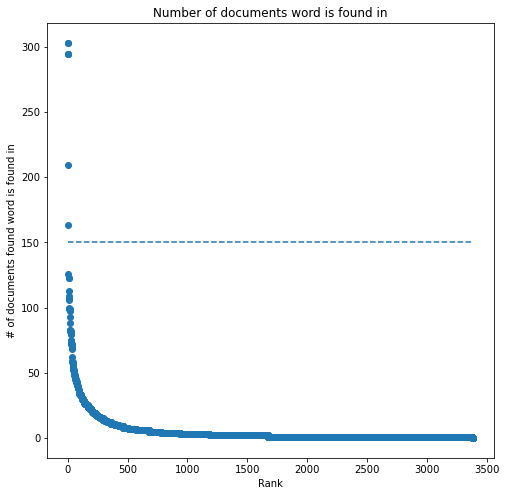

In [215]:
plt.figure(figsize=(8,8))
plt.title('Number of documents word is found in')

plt.scatter(range(tokenizer.get_vocab_size()), (((tfs != 0) * 1).sum(axis=0)).sort_values(ascending=False))
plt.plot([0, tfs.shape[1]], [150, 150], '--')

plt.ylabel('# of documents found word is found in')
plt.xlabel('Rank')
plt.show()

In [216]:
tfs_df, idfs_shifted, tf_idfs_shifted = tfidfs(tokenizer, lines, 150)

top_500 = tf_idfs_shifted.sum(axis=0).sort_values(ascending=False).head(500)
print('Top 500 words in total tf-idf score after DFs shift')
print(tokenizer.decode(np.array(top_500.index)))

Top 500 words in total tf-idf score after DFs shift
coumadin dilantin pneumonia prednisone insulin prophylaxis lisinopril plavix seizure atrial fibrillation constipation ativan lasix keppra blood amiodarone heparin infection to . levofloxacin haldol afib oxycodone / flagyl anxiety morphine albuterol dilaudid control agitation of acetaminophen vancomycin nausea vitamin ivf fever ppi asa lovenox diltiazem pressure e lantus zosyn humalog ceftriaxone prbc n levothyroxine lorazepam warfarin ciprofloxacin tylenol 2 sulfate bactrim contrast acid disease uti phenytoin metformin hypotension with colace calcium protonix steroids k prbcs cefepime lipitor benadryl antibiotics folic pna chemotherapy ffp simvastatin vanco the pantoprazole fluid percocet lithium chronic fluids furosemide hcl dvt cad ibuprofen aspirin medications seizures potassium fentanyl anti dopamine rash beta senna blocker for ( wheezing htn vanc amlodipine s acute a in ) medication sepsis c hypertension chloride back metoprolol 